In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install pyarrow
!pip install pygam
!pip install shap

## Imports

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import math
import re

from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from pygam import LogisticGAM
import xgboost as xgb

import shap  # package used to calculate Shap values

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Start working from the aggregated dataframe produced from `preprocess`.

In [5]:
train_df = pd.read_feather(f'{PATH_FEATURES}/agg_train-6')

# # UNCOMMENT
# test_df = pd.read_feather(f'{PATH_FEATURES}/agg_test')

train_df.head()

,bookingID,distance_sum,acceleration_x_max,acceleration_x_min,acceleration_x_median,acceleration_x_std,acceleration_x_percentile,acceleration_y_max,acceleration_y_min,acceleration_y_median,acceleration_y_std,acceleration_y_percentile,acceleration_z_max,acceleration_z_min,acceleration_z_median,acceleration_z_std,acceleration_z_percentile,gyro_x_max,gyro_x_min,gyro_x_median,gyro_x_std,gyro_x_percentile,gyro_y_max,gyro_y_min,gyro_y_median,gyro_y_std,gyro_y_percentile,gyro_z_max,gyro_z_min,gyro_z_median,gyro_z_std,gyro_z_percentile,Speed_max,Speed_min,Speed_median,Speed_std,Speed_percentile,total_a_max,total_a_min,total_a_median,...,acceleration_z_fo_max,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,roll_fo_min,roll_fo_max,roll_so_min,roll_so_max,roll_sign_change,pitch_fo_min,pitch_fo_max,pitch_so_min,pitch_so_max,pitch_sign_change,acceleration_x_count_above_2,acceleration_x_count_above_3,acceleration_y_count_above_2,acceleration_y_count_above_3,acceleration_z_count_above_2,acceleration_z_count_above_3,second_max,second_count,odd,label,too_far
0,0,9565.105992,4.782614,-4.692294,-0.725250,0.928022,0.347582,-6.119916,-12.764703,-9.622127,0.639934,-8.936234,2.318857,-6.251807,-1.607663,1.141266,-0.210278,0.438371,-0.392537,0.002575,0.065954,0.083481,0.469724,-0.609930,-0.002239,0.100225,0.097003,0.372807,-0.731892,-0.003522,0.063685,0.061658,22.946083,-1.0,8.503366,7.199919,18.748623,12.988328,6.457339,9.852645,...,6.087766,9.125891,10.789780,128.0,0.525470,0.486405,0.972448,0.930134,491.0,0.629634,0.897888,1.315454,1.044398,452.0,0.568942,0.719506,0.698531,1.288449,486.0,0.601279,0.525920,0.929869,1.103402,0.0,0.565893,0.622762,0.912975,1.049871,251.0,77.0,17.0,1004.0,1004.0,309.0,101.0,1589.0,1004,0,0,0
1,1,14328.130507,3.813341,-5.352994,-0.563126,0.744157,0.059367,12.536156,6.623425,9.537963,0.533915,10.133488,1.481293,-5.355455,-2.175822,0.854271,-1.213190,0.126536,-0.125367,-0.001518,0.027740,0.029845,0.470837,-0.678183,-0.003491,0.091699,0.070302,0.235131,-0.121265,-0.000384,0.033838,0.040108,21.882141,-1.0,6.904588,7.059362,18.593060,12.790147,6.970526,9.844748,...,3.441799,7.568512,5.746438,20.0,0.173800,0.238639,0.403154,0.299289,454.0,0.352295,0.372715,0.388964,0.472042,361.0,0.231692,0.206280,0.340217,0.347914,409.0,0.347471,0.434247,0.486340,0.781718,0.0,0.308782,0.333688,0.397189,0.441969,104.0,32.0,7.0,851.0,851.0,546.0,115.0,1034.0,851,0,1,0
2,2,8948.187738,1.956122,-2.971295,0.433364,0.756589,1.145421,13.333716,7.941810,9.814133,0.505693,10.212540,2.312870,-3.282551,0.366324,1.020021,1.235446,0.282162,-0.155218,0.001164,0.053903,0.052843,0.431695,-0.462000,0.001035,0.117321,0.092787,0.255884,-0.125907,0.001764,0.036215,0.032063,9.360483,0.0,2.998761,2.897762,7.260158,13.403410,8.234988,9.877755,...,2.942564,5.363175,5.947378,61.0,0.396452,0.300546,0.665232,0.558331,90.0,0.347582,0.301157,0.391565,0.490525,49.0,0.332922,0.290161,0.623083,0.437990,96.0,0.295072,0.479682,0.647632,0.497192,0.0,0.224242,0.336153,0.424833,0.534245,37.0,1.0,0.0,195.0,195.0,9.0,2.0,825.0,195,0,1,0
3,4,13314.129817,2.019635,-2.866458,-0.381168,0.527220,0.183690,-7.064984,-18.847833,-9.364999,0.598023,-8.921670,0.296381,-9.374869,-2.608658,0.779529,-1.627701,0.438732,-0.420507,-0.022799,0.042342,0.011330,0.652628,-0.506531,0.024504,0.112567,0.136198,0.505220,-0.348189,-0.001147,0.065927,0.064638,19.780001,0.0,3.310000,5.595901,16.135000,21.053265,7.703982,9.791035,...,6.435437,8.689844,13.835532,4.0,0.434474,0.484957,0.894047,0.838916,248.0,0.702851,0.701457,1.298823,1.169583,354.0,0.509004,0.616145,1.086375,0.714633,488.0,0.246631,0.297355,0.461395,0.405312,0.0,0.251567,0.361889,0.568666,0.403067,168.0,12.0,0.0,1094.0,1094.0,908.0,298.0,1094.0,1094,0,1,0
4,6,14628.964066,5.593026,-4.352792,0.47646

In [6]:
len(train_df)

19555

## Feature selection
For the first run, select all 167 features but after running `lightgbm` twice and narrowing the important features into half each run, we are left with 41 features. The 41 features here manage to achieve a higher AUC-ROC score compared to 167 features.

Other features that are excluded from the statistics summary are `Accuracy` and `Bearing`. `Accuracy` refers to how accurate the GPS is in recording the device's position and `Bearing` is merely the direction the driver is heading. Those two do not correspond to the intuition on how they would be able to capture whether is a trip safe or dangerous.

In [0]:
run_model = True # set to False to reproduce the features

In [8]:
exclude = ['label', 'bookingID', 'second_count']

# if we have not run the model to 
# narrow down the features,
# start with 163 features
if not run_model:
    features = [c for c in train_df.columns if c not in exclude]
    
else:
    # # run this line below if trying to reproduce the 41 features
    # features = features_df['features'].tolist()
      
    # excluding second
    # features = ['Speed_max', 'Speed_median', 'horsepower_median', 'gyro_y_max', 'xz_max', 'pitch_count_above_mean', 'gyro_z_kurtosis', 'acceleration_z_std', 'Speed_percentile', 'acceleration_z_kurtosis', 'total_gyro_min', 'roll_absolute_sum_of_changes', 'acceleration_y_count_above_2', 'horsepower_min', 'gyro_y_fo_max', 'acceleration_x_min', 'horsepower_percentile', 'acceleration_y_mean_abs_change', 'roll_std', 'gyro_x_kurtosis', 'roll_gyro_median', 'acceleration_x_count_above_mean', 'gyro_z_count_above_mean', 'gyro_y_count_above_mean', 'roll_so_max', 'gyro_y_kurtosis', 'acceleration_x_mean_abs_change', 'gyro_y_percentile', 'acceleration_z_percentile', 'gyro_y_sign_change', 'acceleration_z_absolute_sum_of_changes', 'acceleration_x_count_above_3', 'acceleration_y_percentile', 'acceleration_z_count_above_mean', 'gyro_x_count_above_mean', 'horsepower_std', 'Speed_std', 'acceleration_x_max', 'acceleration_y_kurtosis', 'gyro_y_so_max']
    
    # including second
    features = ['second_max', 'horsepower_median', 'Speed_max', 'distance_sum', 'Speed_median', 'acceleration_z_std', 'roll_std', 'xz_max', 'Speed_percentile', 'pitch_count_above_mean', 'gyro_y_kurtosis', 'gyro_x_kurtosis', 'acceleration_z_kurtosis', 'total_a_min', 'total_gyro_median', 'gyro_z_count_above_mean', 'acceleration_y_kurtosis', 'gyro_z_percentile', 'gyro_z_kurtosis', 'gyro_y_fo_max', 'acceleration_x_min', 'acceleration_x_count_above_2', 'gyro_y_std', 'gyro_y_count_above_mean', 'acceleration_y_count_above_mean', 'roll_kurtosis', 'total_gyro_min', 'pitch_max', 'acceleration_y_mean_abs_change', 'pitch_gyro_std', 'acceleration_y_absolute_sum_of_changes', 'gyro_y_sign_change', 'roll_gyro_percentile', 'acceleration_z_so_max', 'acceleration_x_so_min', 'total_a_percentile', 'acceleration_y_median', 'pitch_min', 'acceleration_x_count_above_3', 'roll_so_max', 'horsepower_min']

len(features)

41

## Model 1
### Lightgbm
First, run `lightgbm` and perform feature selection by retaining the top half important features for each run.

In [0]:
# ==================
# set random seed and
# use StratifiedKFold 
# for validation
# ==================
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

## HPO
I also tuned for hyperparameters using `hyperopt`.

In [0]:
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample

LGBM_MAX_LEAVES = 2**10 # maximum number of leaves per tree for lgb
LGBM_MAX_DEPTH = 25 # maximum tree depth for lgb
EVAL_METRIC_LGBM_CLASS = 'auc' #lgb classification metric
N_FOLDS = 5

def quick_hyperopt(data, labels, package, num_evals, diagnostic=False, Class=False):
    
    #==========
    # LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        # clear space
        gc.collect()
        
        integer_params = ['max_depth',
                         'num_leaves',
                          'max_bin',
                         'min_data_in_leaf',
                         'min_data_in_bin']
        
        def objective(space_params):
            
            # cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            # extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            if Class:
                cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=True,
                                    early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_CLASS, seed=42)
                best_loss = 1 - cv_results['auc-mean'][-1]
                
            else:
                cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=False,
                                    early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
                best_loss = cv_results['l1-mean'][-1] #'l2-mean' for rmse
            
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        # integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] 
        
        if Class:
            metric_list = ['auc'] # modify as required for other classification metrics
            objective_list = ['binary', 'cross_entropy']
        
        else:
            metric_list = ['MAE', 'RMSE'] 
            objective_list = ['huber', 'gamma', 'fair', 'tweedie']
        
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
                
        best['boosting'] = boosting_list[best['boosting']]['boosting']
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
          
# lgbm_params = quick_hyperopt(train_df[features], train_df['label'], 'lgbm', 100, Class=True)

In [0]:
lgb_params = { # 100 iterations on 163 features
    'bagging_fraction': 0.87,
    'boosting': 'goss',
    'feature_fraction': 0.84,
    'lambda_l1': 1.6293641405766157,
    'lambda_l2': 2.665252495041461,
    'learning_rate': 0.014837591217805427,
    'max_bin': 67,
    'max_depth': 6,
    'metric': 'auc',
    'min_data_in_bin': 173,
    'min_data_in_leaf': 84,
    'min_gain_to_split': 1.82,
    'num_leaves': 854,
    'objective': 'cross_entropy',
    'other_rate': 0.2539865147944331,
    'top_rate': 0.3214104310251218
}

In [0]:
# ==================
# out of fold validation
# ==================
val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

# # UNCOMMENT
# oof_test = np.zeros((len(test_df), ))
# oof_test_skf = np.empty((folds, len(test_df),))

In [13]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']

    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        1000,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=200,
                        verbose_eval=200,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid, 
                              num_iteration=lgb_clf.best_iteration)
    
    # # UNCOMMENT
    # oof_test_skf[fold, :] = lgb_clf.predict(test_df[features],
    #                                         num_iteration=lgb_clf.best_iteration)
    

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
# # UNCOMMENT    
# oof_test[:] = oof_test_skf.mean(axis=0)

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.785516	valid_1's auc: 0.731588
[400]	training's auc: 0.821372	valid_1's auc: 0.736343
[600]	training's auc: 0.84782	valid_1's auc: 0.737502
[800]	training's auc: 0.867178	valid_1's auc: 0.738251
[1000]	training's auc: 0.880582	valid_1's auc: 0.7389
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.880582	valid_1's auc: 0.7389
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.78985	valid_1's auc: 0.732007
[400]	training's auc: 0.823356	valid_1's auc: 0.733399
[600]	training's auc: 0.851363	valid_1's auc: 0.732843
Early stopping, best iteration is:
[479]	training's auc: 0.835298	valid_1's auc: 0.733944
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.789841	valid_1's auc: 0.72643
[400]	training's auc: 0.827768	valid_1's auc: 0.726257
Early stopping, best iteration is:
[290]	training's auc: 0.80809	valid_1'

In [14]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.731750968, std: 0.004735737. All auc: 0.731451283.


The final overall ROC-AUC score is 0.731.

## Feature importance

In [0]:
feature_score = lgb_clf.feature_importance()

features_df = pd.DataFrame({'features': features,
                            'importance': feature_score})

features_df = features_df.sort_values('importance', ascending=False)

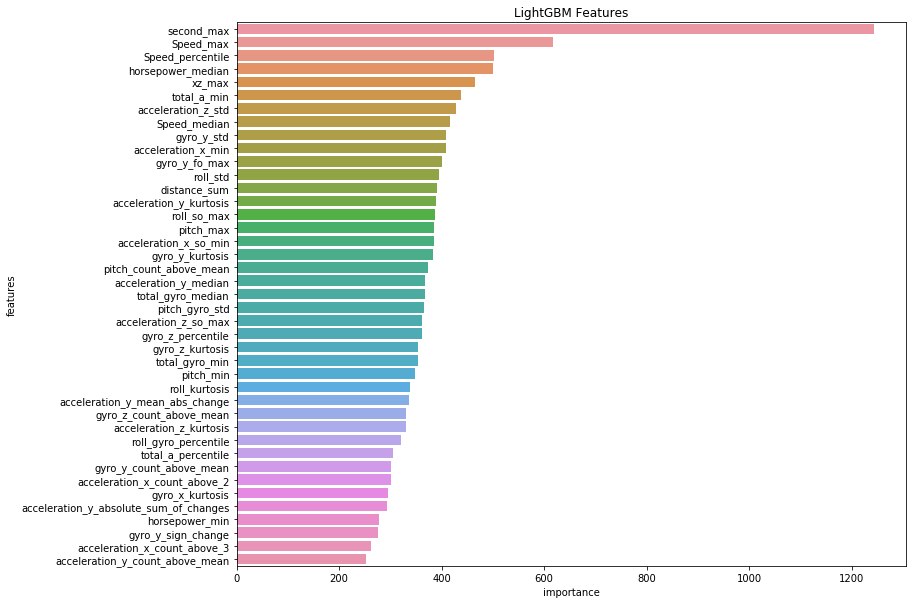

In [16]:
# ran model, set flag to true
run_model = True        

# only plot feature importance 
# for final run
if len(features_df) < 42:
    plt.figure(figsize=(12,10))
    sns.barplot(x="importance", y="features", 
                data=features_df)
    plt.title('LightGBM Features')
    plt.savefig('40_features.png')
    plt.show()

# retain top half important features
if (len(features) > 20):
    features_df = features_df[:int(len(features)/2)]

## Observations
### Leak features
`max_second` happens to be the most predictive variable to whether is a trip safe or dangerous. Removing this "feature" reduces the ROC-AUC from 0.720 to 0.680. 

In my humble opinion, if Grab were to do real-time prediction, this feature has little value from the business or practical point of view. Nevertheless, I am drawing the conclusion that longer trips tend to be more dangerous based on the EDA shown on the previous notebook.

### Top 3 importance features 
Excluding `max_second`, the feature importance plot by `lightgbm` shows that the most predictive feature is `horsepower_median`, `Speed_max`, `Speed_median`. These make sense intuitively since driving at a higher speed indicates driving more dangerously. 

## Submission

In [0]:
# # UNCOMMENT
# submit predictions
# oof_test.to_csv(f'{PATH_FEATURES}/submission.csv')

## Model 2
### Generalized Additive Model
Run `pygam`. Start by selecting smoothing parameters `lam` by doing a `random grid search`.

In [0]:
# ==================
# scale the features
# ==================
s = StandardScaler()

X = s.fit_transform(train_df[features].values)
y = train_df['label'].values

In [0]:
# ==================
# random search for  
# smoothing parameters (lambda)
# code from pygam's documentation
# ==================
np.random.seed(12345)
lams = np.random.rand(5, len(features))
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) 

In [20]:
# ==================
# fit the model
# ==================
%%time
gam = LogisticGAM().gridsearch(X, y, 
                               lam=lams,
                               keep_best=True)

100% (5 of 5) |##########################| Elapsed Time: 0:05:02 Time:  0:05:02


CPU times: user 5min 42s, sys: 1min 17s, total: 6min 59s
Wall time: 5min 2s


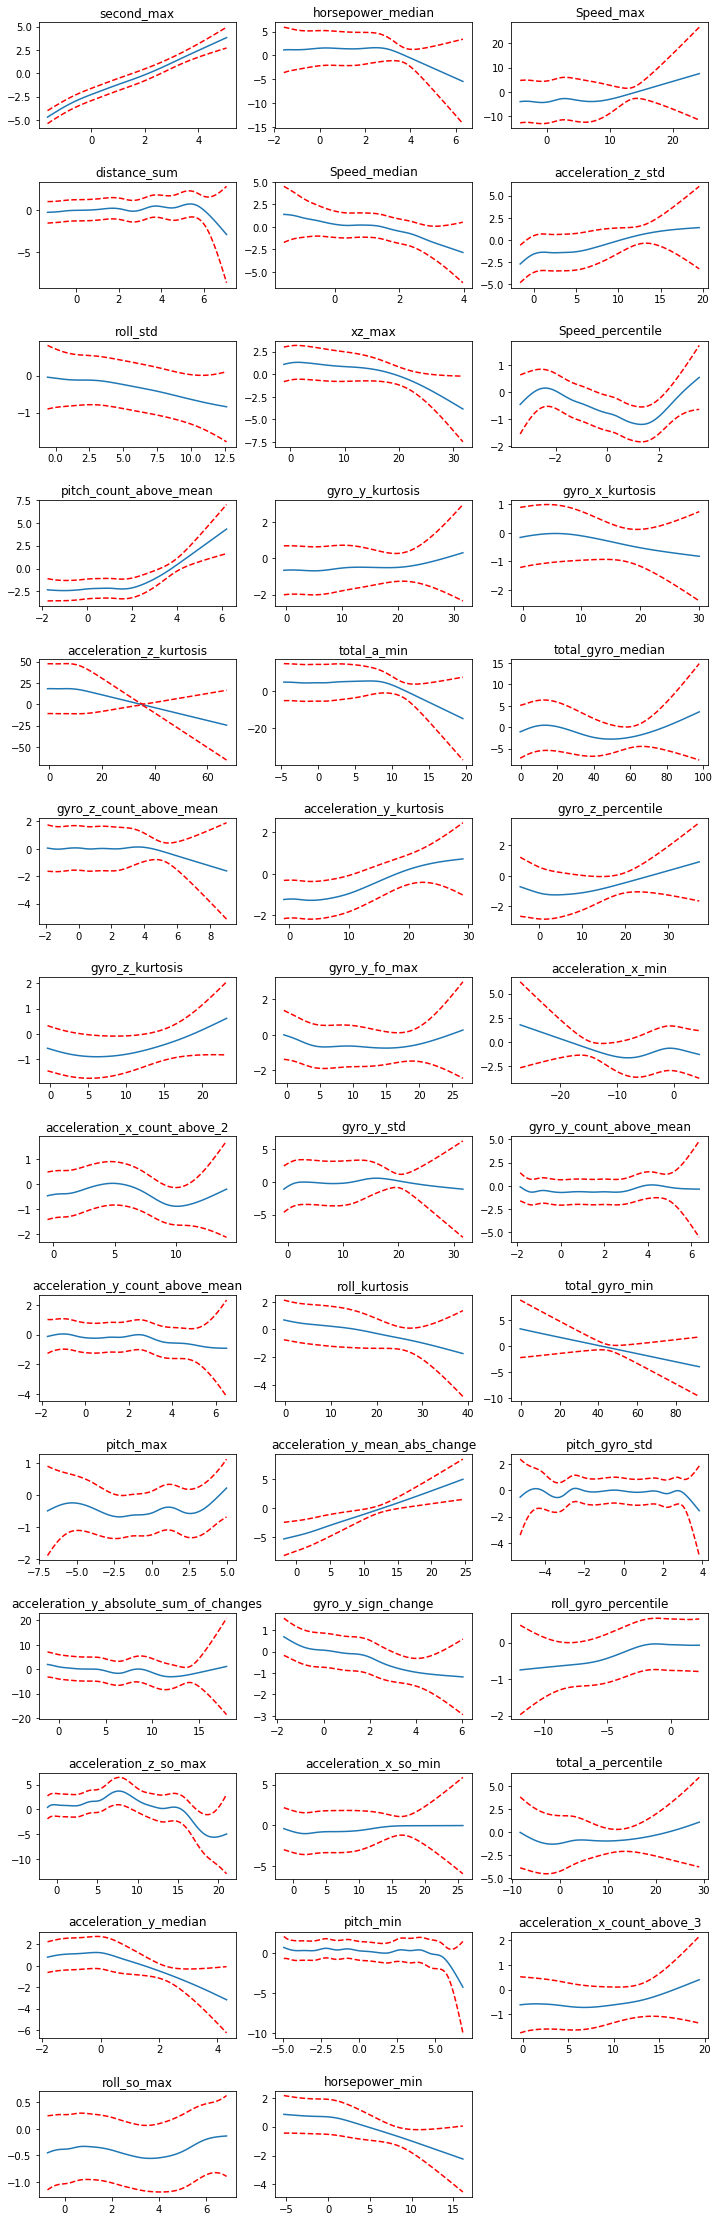

In [21]:
# ==================
# partial dependence plot
# on all features
# ==================
plt.figure(figsize=(12,40))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
        
    plt.subplot(14, 3, i+1)
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')    
    plt.title(features[i])
    plt.subplots_adjust(hspace=0.5)
    
plt.show()

Some obvious trends are when `Speed_max` and `second_max` increases, the higher the tendency it is a dangerous trip.

In [22]:
# ==================
# check for accuracy
# ==================
gam.accuracy(X, y)

0.781181283559192

In [23]:
# ==================
# logistic GAM statistic summary
# ==================
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    215.7077
Link Function:                        LogitLink Log Likelihood:                                 -9324.2583
Number of Samples:                        19555 AIC:                                            19079.9322
                                                AICc:                                           19084.8117
                                                UBRE:                                               2.9845
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1585
Feature Function                  Lam

In [0]:
# ==================
# using the best lambdas
# found, perform KFold
# ==================
random_state = 42
np.random.seed(random_state)

folds = 4
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [25]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
  
    X_train = train_df.iloc[trn_idx][features].values
    y_train = train_df.iloc[trn_idx]['label'].values
    X_valid = train_df.iloc[val_idx][features].values
    y_valid = train_df.iloc[val_idx]['label'].values
    
    gam = LogisticGAM(lam=gam.lam).fit(X_train, y_train)        
    
    p_valid = gam.predict_proba(X_valid)
    
    # ==================
    # impute NaN with 0
    # ==================
    nans = np.where(np.isnan(p_valid))
    
    for i in nans:
        p_valid[i] = 0

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    
    print('fold {}\'s auc: {}'.format(fold+1, val_score))
    
    val_aucs.append(val_score)

fold 1's auc: 0.7332771845071615
fold 2's auc: 0.7266628164149653
fold 3's auc: 0.7266745574994913
fold 4's auc: 0.7304044011315252
CPU times: user 3min 58s, sys: 57.4 s, total: 4min 56s
Wall time: 3min 34s


In [26]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.729254740, std: 0.002778362. All auc: 0.729199533.


## Model 3
### XGBoost

In [0]:
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [0]:
# ==================
# xgb params
# ==================
xgb_params = {
    'objective':'binary:logistic',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'max_depth': 5,
    "seed": random_state
}

In [29]:
len(features)

41

In [30]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_valid, label=y_valid)
        
    xgb_clf = xgb.train(xgb_params,
                        dtrain,
                        5000,
                        evals=[(dtrain, 'train'), (dtest, 'valid')],
                        early_stopping_rounds=100,
                        verbose_eval=100)

    p_valid = xgb_clf.predict(dtest,
                              ntree_limit=xgb_clf.best_ntree_limit)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

[0]	train-error:0.221569	valid-error:0.226483
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.202838	valid-error:0.221115
[200]	train-error:0.183213	valid-error:0.218814
Stopping. Best iteration:
[193]	train-error:0.184172	valid-error:0.218303

[0]	train-error:0.221171	valid-error:0.234978
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.198862	valid-error:0.221427
[200]	train-error:0.180261	valid-error:0.222705
Stopping. Best iteration:
[155]	train-error:0.188251	valid-error:0.220148

[0]	train-error:0.221555	valid-error:0.223472
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.201099	valid-error:0.221682
Stopping. Best iteration:
[5

In [31]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.726312295, std: 0.006152443. All auc: 0.724773307.


## Interpretation
Understanding each feature from the best  model, `lightgbm` using `shap`.

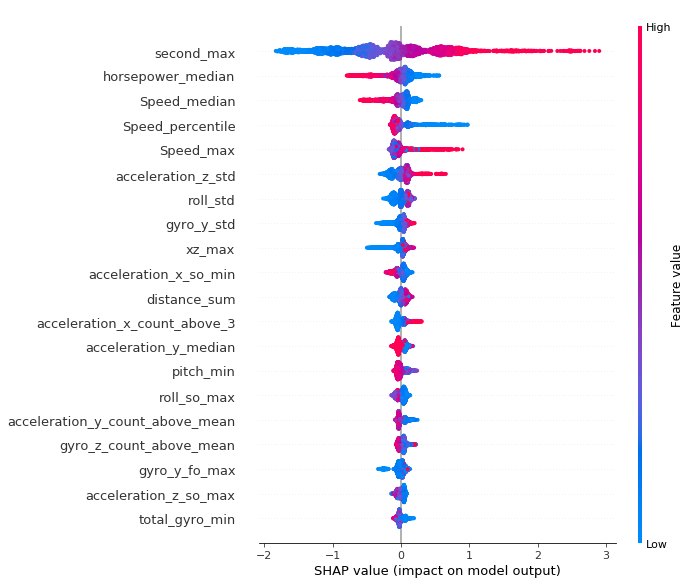

In [32]:
shap_values = shap.TreeExplainer(lgb_clf).shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)

From the plot above, we can tell that summary statistics related to `second_max` has the highest impact on the `label`.

Draw partial depedence plot for the top 10 features.

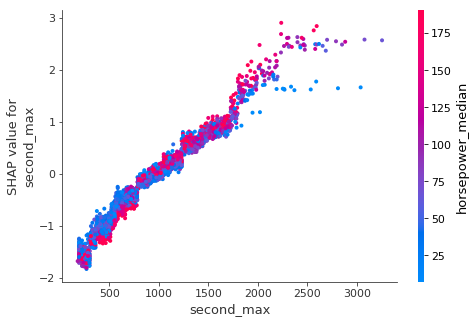

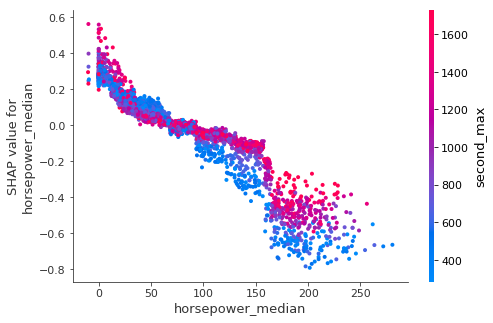

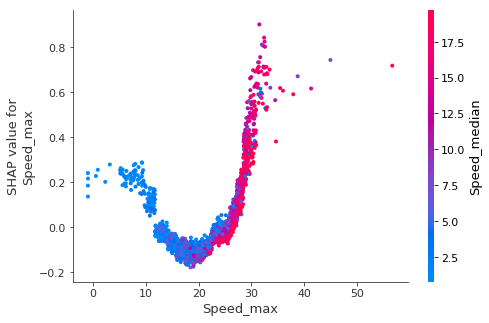

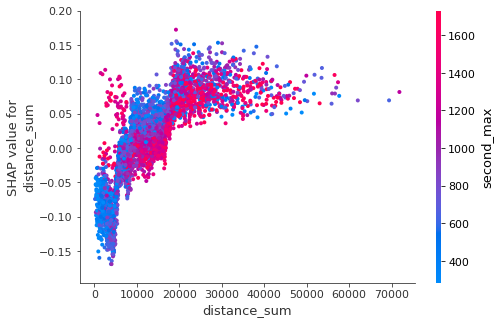

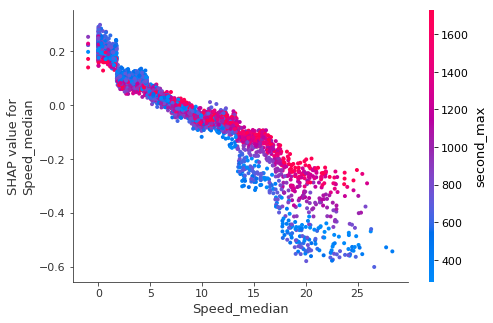

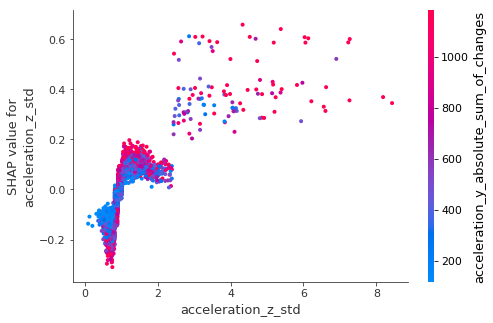

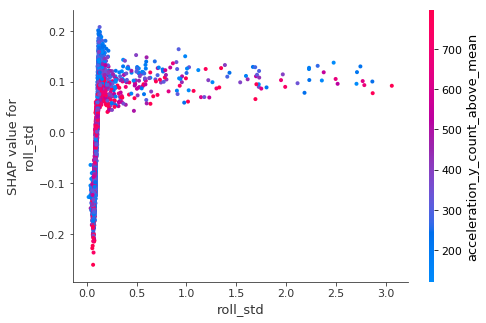

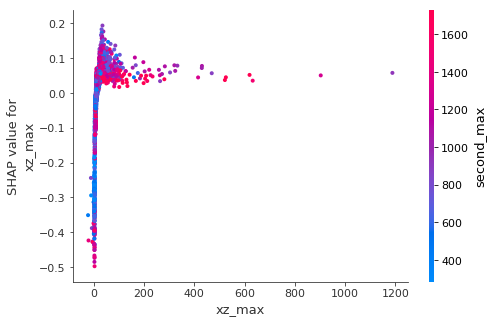

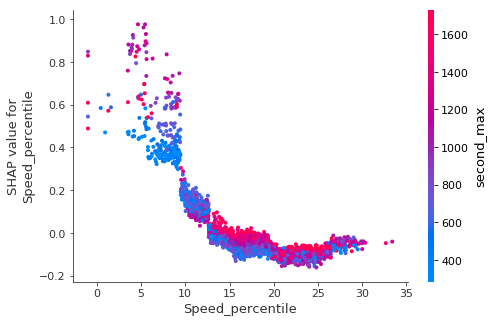

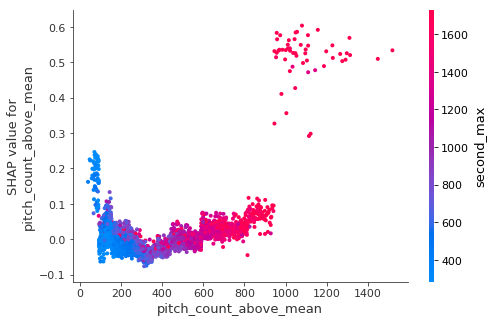

In [33]:
for f in features[:10]:
    shap.dependence_plot(f, shap_values, X_valid)

In [34]:
# from https://github.com/slundberg/shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(lgb_clf)
shap_values = explainer.shap_values(X_valid)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_valid.iloc[0,:])

Features here correspond to the intuition set up in `preprocess.ipynb` earlier. In each trip, we want to extract the maximum speed the driver achieved.

In [0]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization


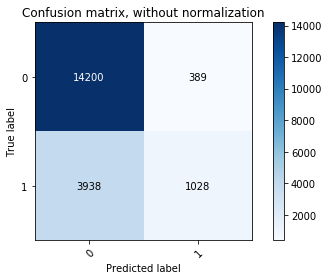

In [36]:
predict_bin = (oof['predict'] > 0.5).astype(int)

# Plot non-normalized confusion matrix
plot_confusion_matrix(oof['label'], predict_bin, classes = np.array([0, 1]),
                      title='Confusion matrix, without normalization')

plt.show()

## What did not work
### Local Outlier Factor

Hypothesis: Outliers in certain readings are most important to predicting whether is a trip dangerous. With that in mind, I tried applying the `LocalOutlierFactor` algorithm from `sklearn` but was not successful.

### Logistic Regression
AUC-ROC was around 0.57.